In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('iam_words'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

iam_words\words.txt
iam_words\Testing_\a01-000u-04-00.png
iam_words\Testing_\a01-000u-05-06.png
iam_words\Testing_\a02-000-01-00.png
iam_words\Testing_\a02-004-00-03.png
iam_words\Testing_\a02-004-08-05.png
iam_words\Testing_\a02-004-09-02.png
iam_words\Testing_\a02-072-00-12.png
iam_words\Testing_\a02-072-03-10.png
iam_words\Testing_\a02-072-06-06.png
iam_words\Testing_\h01-010-04-03.png
iam_words\Testing_\h01-010-06-05.png
iam_words\Testing_\Telugu1.png
iam_words\Testing_\Testing1.png
iam_words\Testing_\Testing2.jpg
iam_words\Testing_\Testing2.png
iam_words\Testing_\Testing3.png
iam_words\Testing_\Testing4.png
iam_words\Testing_\Testing5.png
iam_words\Testing_\Testing6.png
iam_words\Testing_\Time1.png
iam_words\word_data\a01\a01-000u\a01-000u-00-00.png
iam_words\word_data\a01\a01-000u\a01-000u-00-01.png
iam_words\word_data\a01\a01-000u\a01-000u-00-02.png
iam_words\word_data\a01\a01-000u\a01-000u-00-03.png
iam_words\word_data\a01\a01-000u\a01-000u-00-04.png
iam_words\word_data\a01\a01

In [2]:
%pip install opencv-python
%pip install gradio
%pip install torch torchvision transformers
%pip install Levenshtein
import numpy as np
import cv2
import os
import pandas as pd
import string
import matplotlib.pyplot as plt

from keras.preprocessing.sequence import pad_sequences

from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from keras.models import Model
from keras.activations import relu, sigmoid, softmax
import keras.backend as K

from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.saving import register_keras_serializable

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from PIL import Image

import tensorflow as tf

#ignore warnings in the output
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


ModuleNotFoundError: No module named 'tensorflow'

In [3]:
import numpy as np
import pandas as pd
import os
import cv2
import string
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from keras.models import Model, Sequential
from keras.activations import relu, sigmoid, softmax
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import backend as tf_keras_backend
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import Levenshtein as lv

import matplotlib.pyplot as plt
import keras.backend as K

ModuleNotFoundError: No module named 'tensorflow'

In [8]:
images = []
labels = []

RECORDS_COUNT = 30000

train_images = []
train_labels = []
train_input_length = []
train_label_length = []
train_original_text = []

valid_images = []
valid_labels = []
valid_input_length = []
valid_label_length = []
valid_original_text = []

inputs_length = []
labels_length = []

In [9]:
with open('iam_words/words.txt') as f:
    contents = f.readlines()[18:22539]

lines = [line.strip() for line in contents] 
lines[-1]

'b06-110-07-03 ok 173 987 2031 8 6 . .'

In [10]:
def process_image(img):
    """
    Converts image to shape (32, 128, 1) & normalize
    """
    w, h = img.shape
    
#     _, img = cv2.threshold(img, 
#                            128, 
#                            255, 
#                            cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    # Aspect Ratio Calculation
    new_w = 32
    new_h = int(h * (new_w / w))
    img = cv2.resize(img, (new_h, new_w))
    w, h = img.shape
    
    img = img.astype('float32')
    
    # Converts each to (32, 128, 1)
    if w < 32:
        add_zeros = np.full((32-w, h), 255)
        img = np.concatenate((img, add_zeros))
        w, h = img.shape
    
    if h < 128:
        add_zeros = np.full((w, 128-h), 255)
        img = np.concatenate((img, add_zeros), axis=1)
        w, h = img.shape
        
    if h > 128 or w > 32:
        dim = (128,32)
        img = cv2.resize(img, dim)
    
    img = cv2.subtract(255, img)
    
    img = np.expand_dims(img, axis=2)
    
    # Normalize 
    img = img / 255
    
    return img

In [11]:
max_label_len = 0

char_list = "!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz" 

# string.ascii_letters + string.digits (Chars & Digits)
# or 
# "!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"

print(char_list, len(char_list))

def encode_to_labels(txt):
    # encoding each output word into digits
    dig_lst = []
    for index, chara in enumerate(txt):
        dig_lst.append(char_list.index(chara))
        
    return dig_lst

!"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz 78


In [12]:
for index, line in enumerate(lines):
    splits = line.split(' ')
    status = splits[1]
    
    if status == 'ok':
        word_id = splits[0]
        word = "".join(splits[8:])
        
        splits_id = word_id.split('-')
        filepath = 'iam_words/word_data/{}/{}-{}/{}.png'.format(splits_id[0], 
                                                  splits_id[0], 
                                                  splits_id[1], 
                                                  word_id)
      
        # process image
        img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
        try:
            img = process_image(img)
        except:
            continue
            
        # process label
        try:
            label = encode_to_labels(word)
        except:
            continue
        
        if index % 10 == 0:
            valid_images.append(img)
            valid_labels.append(label)
            valid_input_length.append(31)
            valid_label_length.append(len(word))
            valid_original_text.append(word)
        else:
            train_images.append(img)
            train_labels.append(label)
            train_input_length.append(31)
            train_label_length.append(len(word))
            train_original_text.append(word)
        
        if len(word) > max_label_len:
            max_label_len = len(word)
    
    if index >= RECORDS_COUNT:
        break

In [16]:
train_padded_label = pad_sequences(train_labels, 
                             maxlen=max_label_len, 
                             padding='post',
                             value=len(char_list))

valid_padded_label = pad_sequences(valid_labels, 
                             maxlen=max_label_len, 
                             padding='post',
                             value=len(char_list))


In [13]:
train_labels[3101]

[70, 67, 56, 65, 55, 60, 65, 58]

In [17]:
train_padded_label[0]

array([38, 40, 47, 30, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78])

In [18]:
train_padded_label.shape, valid_padded_label.shape

((18074, 17), (2007, 17))

In [19]:
train_images = np.asarray(train_images)
train_input_length = np.asarray(train_input_length)
train_label_length = np.asarray(train_label_length)

valid_images = np.asarray(valid_images)
valid_input_length = np.asarray(valid_input_length)
valid_label_length = np.asarray(valid_label_length)

In [20]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import backend as tf_keras_backend
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten

tf_keras_backend.set_image_data_format('channels_last')
tf_keras_backend.image_data_format()

'channels_last'

In [21]:
def Model1():
    # input with shape of height=32 and width=128 
    inputs = Input(shape=(32,128,1))

    # convolution layer with kernel size (3,3)
    conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)
    # poolig layer with kernel size (2,2)
    pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)

    conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)
    pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)

    conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)

    conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(conv_3)
    # poolig layer with kernel size (2,1)
    pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)

    conv_5 = Conv2D(512, (3,3), activation = 'relu', padding='same')(pool_4)
    # Batch normalization layer
    batch_norm_5 = BatchNormalization()(conv_5)

    conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_5)
    batch_norm_6 = BatchNormalization()(conv_6)
    pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)

    conv_7 = Conv2D(512, (2,2), activation = 'relu')(pool_6)

    #squeezed = Lambda(lambda x: tf.squeeze(x, 1), output_shape=(31, 512))(conv_7)
    from keras.saving import register_keras_serializable
    @register_keras_serializable()
    def squeeze_function(x):
        return tf.squeeze(x, 1)
    squeezed = Lambda(squeeze_function, output_shape=(31, 512))(conv_7)

    # bidirectional LSTM layers with units=128
    blstm_1 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(squeezed)
    blstm_2 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(blstm_1)

    outputs = Dense(len(char_list)+1, activation = 'softmax')(blstm_2)

    # model to be used at test time
    act_model = Model(inputs, outputs)
    
    return act_model,outputs,inputs
act_model,outputs,inputs=Model1()

In [22]:
act_model,outputs,inputs=Model1()

In [23]:
act_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 128, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 128, 64)    │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 32, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 8, 32, 256)     │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 8, 32, 256)     │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 4, 32, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 4, 32, 512)     │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 32, 512)     │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 4, 32, 512)     │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 32, 512)     │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 2, 32, 512)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 1, 31, 512)     │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 31, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 31, 512)        │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 31, 512)        │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 31, 79)         │        40,527 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,743,247 (33.35 MB)

 Trainable params: 8,741,199 (33.35 MB)

 Non-trainable params: 2,048 (8.00 KB)

In [24]:
the_labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    return tf.keras.backend.ctc_batch_cost(labels, y_pred, input_length, label_length)

loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, the_labels, input_length, label_length])

#model to be used at training time
model = Model(inputs=[inputs, the_labels, input_length, label_length], outputs=loss_out)

In [25]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

class CTCLossLayer(Layer):
    def call(self, inputs):
        y_pred, labels, input_length, label_length = inputs
        return tf.keras.backend.ctc_batch_cost(labels, y_pred, input_length, label_length)


In [29]:
# Custom CTC Loss Layer
loss_out = CTCLossLayer(name='ctc')([outputs, the_labels, input_length, label_length])

# Model for training
model = Model(inputs=[inputs, the_labels, input_length, label_length], outputs=loss_out)


In [26]:
batch_size = 5
epochs = 25
e = str(epochs)
optimizer_name = 'sgd'

In [27]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = optimizer_name, metrics=['accuracy'])

filepath="{}o-{}r-{}e-{}t-{}v.keras".format(optimizer_name,
                                          str(RECORDS_COUNT),
                                          str(epochs),
                                          str(train_images.shape[0]),
                                          str(valid_images.shape[0]))

checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]

In [28]:
#Training the model

history = model.fit(x={'image': train_images, 'the_labels': train_padded_label, 'input_length': train_input_length, 'label_length': train_label_length},
                    y=np.zeros(len(train_images)),
                    batch_size=batch_size, 
                    epochs=epochs, 
                    validation_data=({'image': valid_images, 'the_labels': valid_padded_label, 'input_length': valid_input_length, 'label_length': valid_label_length}, [np.zeros(len(valid_images))]),
                    verbose=1,
                    callbacks=callbacks_list)

Epoch 1/25


ValueError: Missing data for input "input_layer_1". You passed a data dictionary with keys ['image', 'the_labels', 'input_length', 'label_length']. Expected the following keys: ['input_layer_1', 'the_labels', 'input_length', 'label_length']

In [30]:
filepath='sgdo-30000r-25e-18074t-2007v.keras'
# Load the saved best model weights
act_model.load_weights(filepath)

# Predict outputs on validation images
prediction = act_model.predict(valid_images)

# Use CTC decoder (Greedy decoding)
decoded, log_probabilities = tf.keras.backend.ctc_decode(prediction, 
                                                         input_length=np.ones(prediction.shape[0]) * prediction.shape[1], 
                                                         greedy=True)

# Convert decoded predictions to text (you may need to adjust for the actual char_list)
out = []

# Iterate over each decoded sequence (this is a list of lists)
for seq in decoded:
    # Extract and flatten the tensor (if it is multi-dimensional)
    seq = seq.numpy().flatten()  # Flatten to a 1D array if it's multi-dimensional
    out.append([char_list[int(x)] for x in seq if x != -1])  # Ignore -1 (padding or empty tokens)

import Levenshtein as lv
correct_predictions = 0

total_jaro = 0

# Calculate Jaro distance for each prediction
for i, x in enumerate(out):
    letters = ''.join(x)  # Join the list of characters into a string
    if letters == valid_original_text[i]:
        correct_predictions += 1
    total_jaro += lv.jaro(letters, valid_original_text[i])
    
accuracy = correct_predictions / len(valid_original_text)
average_jaro = total_jaro / len(out)

# Print the average Jaro score
#print(f"Accuracy: {accuracy * 100:.2f}%")
print('Jaro :', total_jaro / len(out))

63/63 ━━━━━━━━━━━━━━━━━━━━ 26s 394ms/step
Jaro : 0.666703952274422


In [31]:
#Trying to calculate the accuracy/instead training model again.

correct_predictions = 0
total_jaro = 0
import Levenshtein as lv

for i, x in enumerate(out):
    letters = ''.join(x)
    if letters == valid_original_text[i]:
        correct_predictions += 1
    total_jaro += lv.jaro(letters, valid_original_text[i])

accuracy = correct_predictions / len(valid_original_text)
average_jaro = total_jaro / len(out)

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Average Jaro Similarity: {average_jaro:.2f}")


Accuracy: 0.00%
Average Jaro Similarity: 0.67


In [32]:
complete_model_filepath = "complete_model.keras"
act_model.save(complete_model_filepath)
print(f"Model saved to {complete_model_filepath}")

Model saved to complete_model.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
original_text =  that
predicted text = that


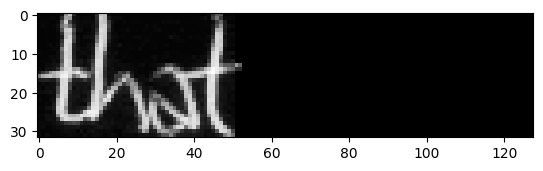

original_text =  want
predicted text = wut


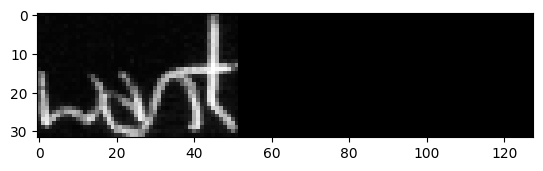

original_text =  in
predicted text = in


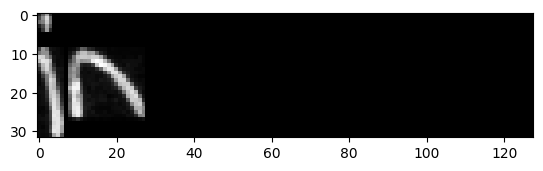

original_text =  ,
predicted text = ,


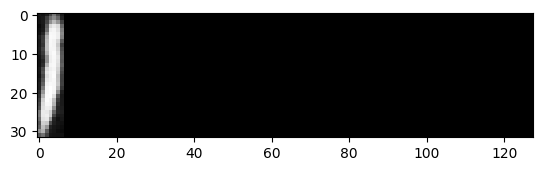

original_text =  .
predicted text = .


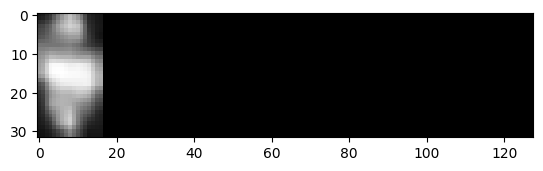

original_text =  who
predicted text = who


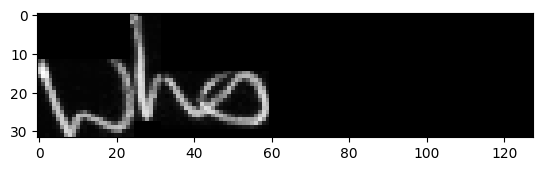

original_text =  .
predicted text = .


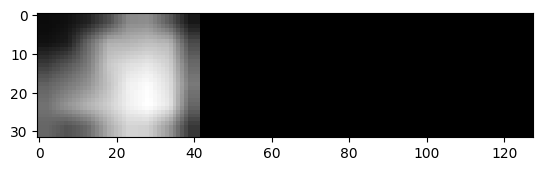

In [33]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

i = 2000  # 1980
j = 3100  # 2100

prediction = act_model.predict(valid_images[i:j])  # Use tf.keras CTC decode
decoded = tf.keras.backend.ctc_decode(
    prediction, 
    input_length=np.ones(prediction.shape[0]) * prediction.shape[1], 
    greedy=True
)[0][0]
out = decoded.numpy()

# See the results
for k, x in enumerate(out):
    print("original_text = ", valid_original_text[i+k])
    print("predicted text = ", end='')
    for p in x:
        if int(p) != -1:
            print(char_list[int(p)],     end='')
    print()  # Add a newline after printing the predicted text
    plt.imshow(valid_images[i+k].reshape(32,128), cmap=plt.cm.gray)
    plt.show()

In [140]:
#import string
#char_list = string.ascii_letters + string.digits + " .,;?!"

In [ ]:
print("Decoded shape:", decoded.shape)

In [ ]:
#Predited text (Karthik's last cell --failed one -- needs to resolve.)

# Print predicted probabilities for each time step for debugging
for i, timestep in enumerate(prediction[0]):
    print(f"Time step {i}: {timestep}")

# Use tf.keras CTC decode with correct input lengths
input_length = np.ones(prediction.shape[0]) * prediction.shape[1]
decoded = tf.keras.backend.ctc_decode(
    prediction,
    input_length=input_length,
    greedy=True
)[0][0]

# Print decoded tensor before flattening for debugging
print("Decoded tensor before flattening:", decoded)

# Convert decoded output to a flat numpy array
decoded_array = decoded.numpy().flatten()  # Shape becomes (31,)
print("Decoded array:", decoded_array)

# Print predicted text based on decoded array
predicted_text = ""
for char_index in decoded_array:
    if int(char_index) != -1:  # Filter out padding characters (-1)
        char = char_list[int(char_index)]
        predicted_text += char

print("Predicted text:", predicted_text)

In [ ]:
%pip install gradio

In [1]:
%pip install torch torchvision transformers gradio


  Using cached sympy-1.13.1-py3-none-any.whl (6.2 MB)
  Using cached networkx-3.2.1-py3-none-any.whl (1.6 MB)
  Using cached mpmath-1.3.0-py3-none-any.whl (536 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
  Using cached uvicorn-0.34.0-py3-none-any.whl (62 kB)
  Using cached aiofiles-23.2.1-py3-none-any.whl (15 kB)
  Using cached semantic_version-2.10.0-py2.py3-none-any.whl (15 kB)
  Using cached pydub-0.25.1-py2.py3-none-any.whl (32 kB)
  Using cached httpx-0.28.1-py3-none-any.whl (73 kB)
  Using cached python_multipart-0.0.20-py3-none-any.whl (24 kB)
  Using cached ffmpy-0.5.0-py3-none-any.whl (6.0 kB)
  Using cached sniffio-1.3.1-py3-none-any.whl (10 kB)
  Using cached httpcore-1.0.7-py3-none-any.whl (78 kB)
  Using cached h11-0.14.0-py3-none-any.whl (58 kB)
  Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
  Using cached pyparsing-3.2.1-py3-none-any.whl (107 kB)
  Using cached annotated_types-0.7.0-py3-none-any.whl (13 kB)
  Using cached shellingham-1.5.4-py2.py3-non

ERROR: Could not install packages due to an OSError: [Errno 28] No space left on device

You should consider upgrading via the 'd:\Handwritten_Sentence_Recognition\Text_recognition\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [1]:
import gradio as gr
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
import requests

# Load the processor and model
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-handwritten')
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-handwritten')

def recognize_text(image):
    """
    Process an uploaded handwritten image and extract text using a trained OCR model.
    """
    try:
        # Preprocess the image
        pixel_values = processor(images=image, return_tensors="pt").pixel_values
        # Generate predictions
        generated_ids = model.generate(pixel_values)
        # Decode the generated text
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
        if not generated_text.strip():
            return "Unrecognized image value. Please try a different image."
        return generated_text
    except Exception as e:
        return f"Error processing image: {str(e)}"

# Define the interface
interface = gr.Interface(
    fn=recognize_text,
    inputs=gr.Image(
        type="pil", 
        label="Upload a Handwritten Image"  # Allow image editing for user convenience
    ),
    outputs=gr.Textbox(
        label="Recognized Text", 
        lines=5, 
        placeholder="The extracted text will appear here."
    ),
    title="✨ Handwritten Text & Sentence Recognition Tool 🎨",
    description=(
        "This application leverages AI to recognize text from handwritten images. "
        "Simply upload an image of handwritten text, and the tool will process it to provide the digital text. "
        "Ensure the handwriting is clear for the best results. 🎯"
    ),
    article=(
        """
        ### How It Works:
        - **Upload Image**: Choose or drag an image of handwritten text.
        - **AI Processing**: The image is processed using a state-of-the-art model.
        - **Result**: The recognized text is displayed for you to copy.
        
        #### Tips for Best Results:
        - Use high-quality images with clear handwriting.
        - Avoid images with too much noise or overlapping text.
        
        ### Developed by:
        - Mohammad Ghouse, J Manoj & Team
        - Under the guidance of Dr. Yeresime Suresh, HoD of CSE (AI), BITM
        #### Powered By:
        - **Gradio**: For an interactive and user-friendly experience.
        """
    ),
    theme="compact"  # Optional: Apply a compact theme for aesthetic presentation
)

# Launch the interface
if __name__ == "__main__":
    interface.launch()


d:\Handwritten_Sentence_Recognition\Text_recognition\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "v

* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
